In [1]:
# Improve by ChatGPT & GitHub Copilot
# Running the requierements.ipynb
%run /bettik/PROJECTS/pr-data-ocean/riverama/Notebooks/requierements.ipynb

# Running functions_bar_igw.ipynb
%run /bettik/PROJECTS/pr-data-ocean/riverama/Notebooks/OSSE_borrador/IGW_BAR/functions_bar_igw.ipynb

Loadig data

In [2]:
path_to_mask = "/bettik/PROJECTS/pr-data-ocean/riverama/Datos/CALEDO60/1_mesh_mask_TROPICO12_L125_tr21.nc" # in numpy .npy format
path_to_input = "/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_hf/ssh_hf_" # including the file name prefix 
path_to_save = "/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_bar/" # including the file name prefix 

# Loading ssh_hf and making and selecting 1h for testing
ssh_hf = xr.open_mfdataset(path_to_input + "01.nc")
ds = ssh_hf.rename({'__xarray_dataarray_variable__': 'ssh_hf'}).sel(time_counter=pd.to_datetime('2014-01-10T00:30:00')).load()

# Loading Mask
mask = xr.open_dataset(path_to_mask,drop_variables={"x","y"}) 
mask = mask.tmaskutil[0,:,:].values

Mask, Coarsen, axis, grid2D and filled

In [3]:
ssh_hf = ds.ssh_hf.where(mask==1,np.nan) # change false by 1, otherwise everithing is nan
# print('mask: ok')

ssh_hf = ssh_hf.coarsen(x=4, y=4, boundary='trim').mean()
# print('coarsen: ok')

x_axis = Axis(ssh_hf.x.values,is_circle=True)
y_axis = Axis(ssh_hf.y.values,is_circle=True)
# print('x_axis,y_axis: ok') # t_axis no longer needed    

grid = Grid2D(y_axis, x_axis, ssh_hf.values.transpose(0,1))
# print('grid: ok') 

has_converged, filled = fill.gauss_seidel(grid) # we do not need to transpose, cause we are not concern by t_axis
#print('convergence =', has_converged)
# print('filled: ok')

ssh_hf_filled = ssh_hf.copy(deep=True,data=filled) # is it ok?
# print('copy: ok')

/tmp/ipykernel_353328/2604367313.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(ssh_hf_filled.lon, ssh_hf_filled.lat, ssh_hf_filled, cmap=cmocean.cm.curl, vmin=min_val, vmax=max_val)


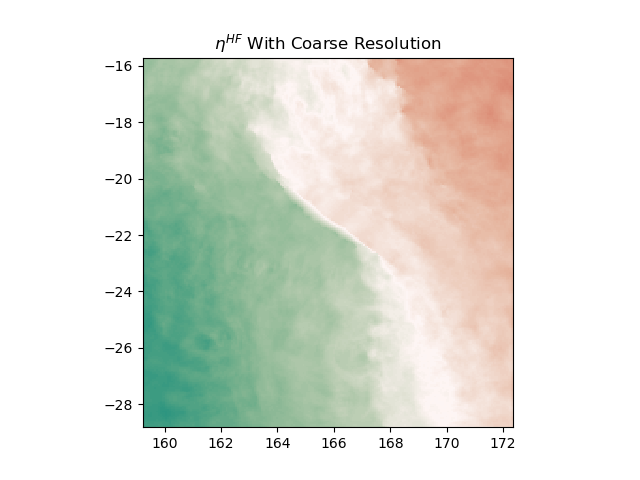

In [4]:
min_val = -1
max_val = 1


plt.figure()
plt.pcolormesh(ssh_hf_filled.lon, ssh_hf_filled.lat, ssh_hf_filled, cmap=cmocean.cm.curl, vmin=min_val, vmax=max_val)
plt.title('$\eta^{HF}$ With Coarse Resolution')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

To cartesian grid

In [5]:
dx = 10 # in kilometers

ENSLAT2D, ENSLON2D, i_lat, i_lon = create_cartesian_grid(ssh_hf_filled.lat[:,0].values,
                                                            ssh_hf_filled.lon[0,:].values,
                                                            dx)
# print("#### ENSLAT2D ####")
# print(ENSLAT2D)
# print("#### ENSLON2D #### ")
# print(ENSLON2D)
# print("#### i_lat #### ")
# print(i_lat)
# print("#### i_lon ####")
# print(i_lon)  
  

In [6]:
# Create a new DataArray with the filled data
ssh_hf_filled = xr.DataArray(
    data=filled,
    dims=['y', 'x'],
    coords={'y': ssh_hf.y, 'x': ssh_hf.x, 'lat': (['y', 'x'], ssh_hf.lat.data), 'lon': (['y', 'x'], ssh_hf.lon.data)}
)

dx = 10  # in kilometers

ENSLAT2D, ENSLON2D, i_lat, i_lon = create_cartesian_grid(ssh_hf_filled.lat[:, 0].values,
                                                         ssh_hf_filled.lon[0, :].values,
                                                         dx)

ENSLAT2D_flat = ENSLAT2D.flatten()
ENSLON2D_flat = ENSLON2D.flatten()

points = np.column_stack((ssh_hf_filled.lat.data.flatten(), ssh_hf_filled.lon.data.flatten()))
values = ssh_hf_filled.data.flatten()
target_grid = np.column_stack((ENSLAT2D_flat, ENSLON2D_flat))

array_cart_ssh = griddata(points, values, target_grid, method='linear')

array_cart_ssh = array_cart_ssh.reshape(ENSLAT2D.shape)

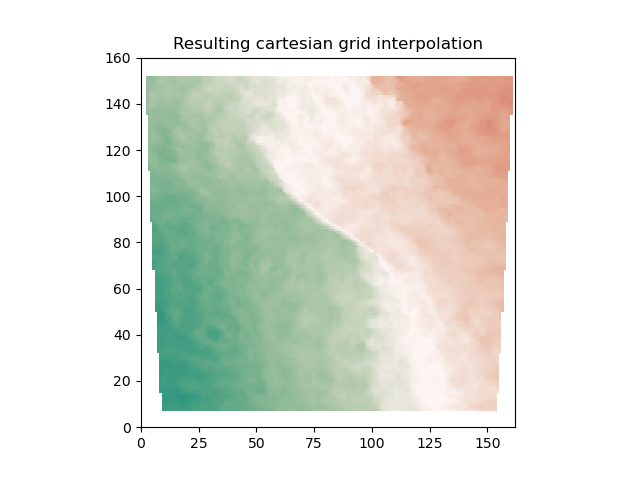

In [7]:
plt.figure()
plt.pcolormesh(array_cart_ssh, cmap=cmocean.cm.curl, vmin=min_val, vmax=max_val)
plt.title('Resulting cartesian grid interpolation')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

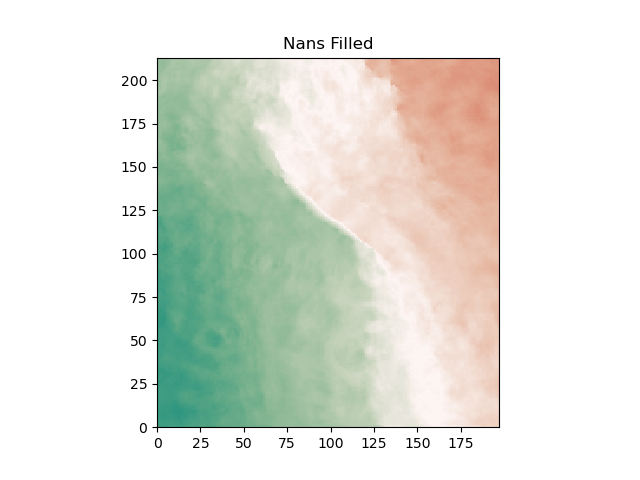

In [8]:
plt.figure()
plt.pcolormesh(filled, cmap=cmocean.cm.curl, vmin=min_val, vmax=max_val)
plt.title('Nans Filled')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [10]:
# EXTRACTING BAROTROPIC TIDE # 
cart_ssh_filtered = np.array(extract_bar_tide(cart_ssh_hf.values, dx))

AttributeError: 'numpy.ndarray' object has no attribute 'values'

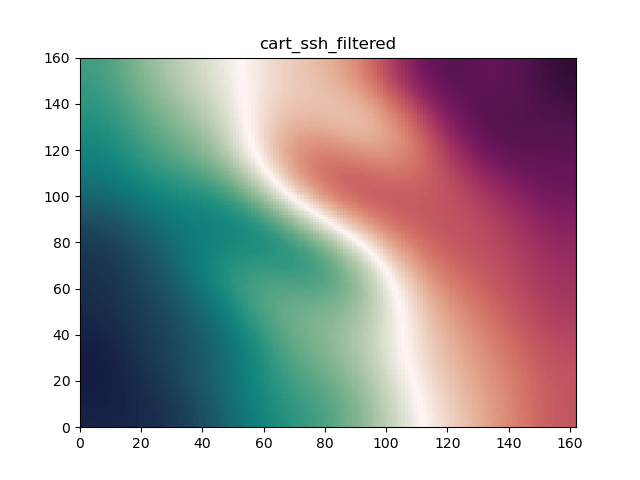

In [12]:
plt.figure()
plt.pcolormesh(cart_ssh_filtered, cmap=cmocean.cm.curl)
plt.title('cart_ssh_filtered')
plt.show()

In [13]:
#lon2d, lat2d = np.meshgrid(ssh_hf.lon.values, ssh_hf.lat.values)
lon2d, lat2d = np.meshgrid(ssh_hf.lon[0,:].values, ssh_hf.lat[:,0].values)

In [14]:
geo_filtered = np.array([griddata(
    np.array([ENSLAT2D.flatten(), ENSLON2D.flatten()]).T,  
    cart_ssh_filtered.flatten(),                        
    (lat2d, lon2d),                                       
    method='linear'                                         
)])


geo_filtered_da = xr.DataArray(
    data=geo_filtered[0], 
    dims=["lat", "lon"],   # Dimensions
    coords={"lat": lat2d[:, 0], "lon": lon2d[0, :]},  # Coordinates
    name="geo_filtered"  # Name 
)

# plt.figure()
# plt.pcolormesh(geo_filtered_da.lon, geo_filtered_da.lat, geo_filtered_da, cmap=cmocean.cm.curl)
# plt.grid(True, which='both')
# plt.show()

In [15]:
# Define the axes correctly using pyinterp.Axis
x_axis = pyinterp.Axis(geo_filtered_da.lon.values, is_circle=True)
y_axis = pyinterp.Axis(geo_filtered_da.lat.values, is_circle=True)
    
# Prepare the grid using pyinterp.Grid2D
grid = pyinterp.Grid2D(y_axis, x_axis, geo_filtered_da.values)

# Apply Gauss-Seidel method to fill data
has_converged, geo_filtered_da_filled = pyinterp.fill.gauss_seidel(grid, num_threads=16)

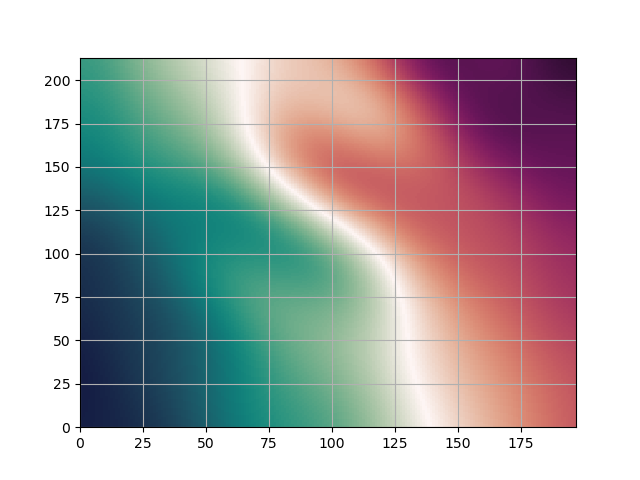

In [16]:
plt.figure()
plt.pcolormesh(geo_filtered_da_filled, cmap=cmocean.cm.curl)
plt.grid(True, which='both')
plt.show()

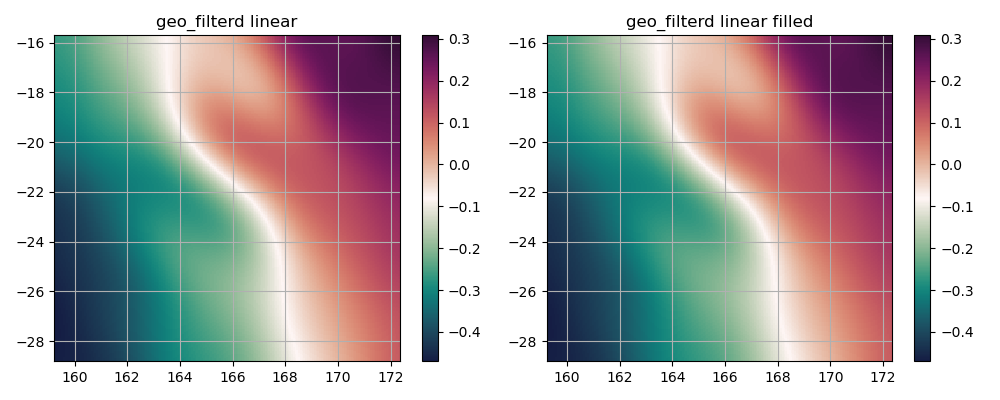

In [17]:
# Create a figure with two subplots side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plot the first pcolormesh on the first subplot
c1 = ax[0].pcolormesh(geo_filtered_da.lon, geo_filtered_da.lat, geo_filtered_da, cmap=cmocean.cm.curl)
ax[0].grid(True, which='both')
ax[0].set_title('geo_filterd linear')

# Plot the second pcolormesh on the second subplot
c2 = ax[1].pcolormesh(geo_filtered_da.lon, geo_filtered_da.lat, geo_filtered_da_filled, cmap=cmocean.cm.curl)
ax[1].grid(True, which='both')
ax[1].set_title('geo_filterd linear filled')

# Add colorbars to each subplot
fig.colorbar(c1, ax=ax[0])
fig.colorbar(c2, ax=ax[1])

# Show the figure
plt.tight_layout()
plt.show()

In [18]:
ssh_igw = ssh_hf_filled - geo_filtered_da_filled

In [19]:
ssh_igw

<xarray.DataArray (y: 213, x: 197)> Size: 336kB
array([[ 0.00381964,  0.00351807,  0.00280833, ...,  0.01276318,
         0.01616427,  0.01192613],
       [ 0.00075431,  0.00685525,  0.00529611, ...,  0.01453973,
         0.00953861,  0.01528196],
       [-0.0012903 ,  0.00532322,  0.00280832, ...,  0.01647698,
         0.00932599,  0.0146416 ],
       ...,
       [-0.02307543, -0.01277894, -0.01690648, ..., -0.00253651,
        -0.00822654,  0.00018924],
       [-0.02183834, -0.0124345 , -0.01551135, ..., -0.00495727,
        -0.00726415,  0.00945102],
       [-0.022002  , -0.01898177, -0.01398971, ...,  0.00681844,
         0.0114585 ,  0.02039118]])
Coordinates:
  * y        (y) int64 2kB 0 1 2 3 4 5 6 7 8 ... 205 206 207 208 209 210 211 212
  * x        (x) int64 2kB 0 1 2 3 4 5 6 7 8 ... 189 190 191 192 193 194 195 196
    lat      (y, x) float32 168kB -28.78 -28.78 -28.78 ... -15.74 -15.74 -15.74
    lon      (y, x) float32 168kB 159.3 159.3 159.4 159.5 ... 172.2 172.3 172.3

/tmp/ipykernel_2975720/721973003.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(ssh_igw.lon, ssh_igw.lat, ssh_igw, cmap=cmocean.cm.curl, vmin=min_val, vmax=max_val)


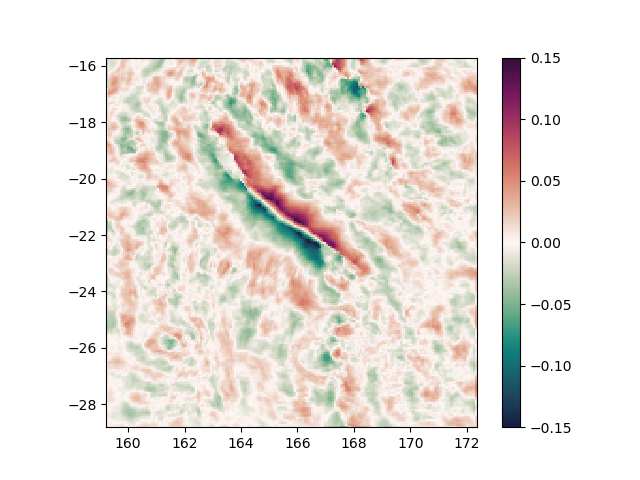

In [20]:
min_val = -0.15
max_val = 0.15

plt.figure()
plt.pcolormesh(ssh_igw.lon, ssh_igw.lat, ssh_igw, cmap=cmocean.cm.curl, vmin=min_val, vmax=max_val)
plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


/tmp/ipykernel_2975720/866632680.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(ssh_hf_filled.lon, ssh_hf_filled.lat, ssh_hf_filled, cmap=cmocean.cm.curl, vmin=min_val, vmax=max_val)


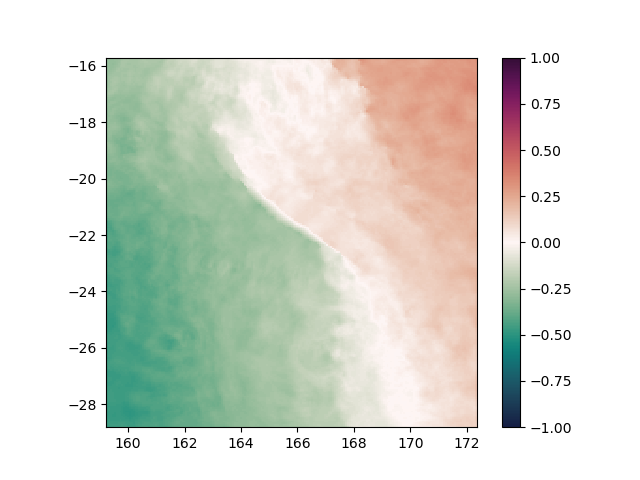

In [21]:
min_val = -1
max_val = 1

plt.figure()
plt.pcolormesh(ssh_hf_filled.lon, ssh_hf_filled.lat, ssh_hf_filled, cmap=cmocean.cm.curl, vmin=min_val, vmax=max_val)
plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [22]:
geo_filtered_da_filled

array([[-0.46595534, -0.46557167, -0.46513239, ...,  0.10486434,
         0.10689447,  0.10878141],
       [-0.46626775, -0.46586573, -0.46540037, ...,  0.10503965,
         0.10706433,  0.10893589],
       [-0.46656271, -0.46614335, -0.46566097, ...,  0.10522061,
         0.10724162,  0.10909768],
       ...,
       [-0.2645309 , -0.26425053, -0.26373244, ...,  0.30616438,
         0.30664906,  0.30688464],
       [-0.26402306, -0.26374572, -0.26322946, ...,  0.30693894,
         0.30741317,  0.3076341 ],
       [-0.26355984, -0.26328551, -0.26276367, ...,  0.30761904,
         0.30808592,  0.30828833]])

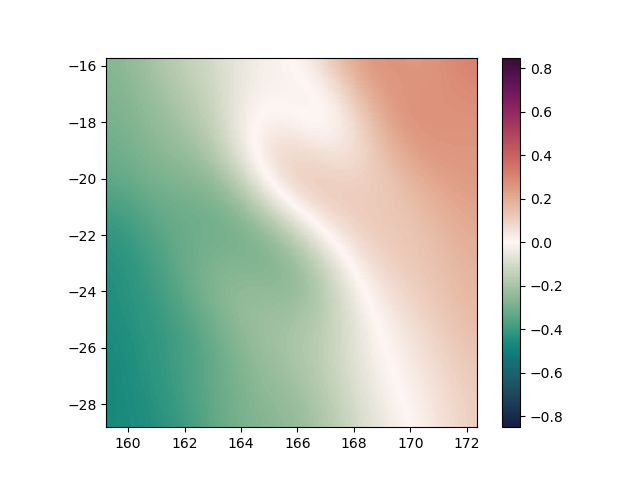

In [23]:
min_val = -0.85
max_val = 0.85

plt.figure()
plt.pcolormesh(geo_filtered_da.lon, geo_filtered_da.lat, geo_filtered_da_filled, cmap=cmocean.cm.curl, vmin=min_val, vmax=max_val)
plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [24]:
# Loading ssh_hf and making and selecting 1h for testing
ssh_bm = xr.open_mfdataset("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_bm/ssh_bm_01.nc").sel(time_counter=pd.to_datetime('2014-01-10T00:30:00')).load()

In [25]:
ssh = xr.open_mfdataset("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/CALEDO60_dedac/ssh_dedac_masked_01.nc").sel(time_counter=pd.to_datetime('2014-01-10T00:30:00')).load()

In [26]:
lat = ssh_bm['lat']
lon = ssh_bm['lon']
time_counter = ssh_bm['time_counter']

In [27]:
ssh_bm

<xarray.Dataset> Size: 11MB
Dimensions:                        (y: 853, x: 788)
Coordinates:
    lat                            (y, x) float32 3MB -28.8 -28.8 ... -15.7
    lon                            (y, x) float32 3MB 159.2 159.2 ... 172.3
    time_counter                   datetime64[ns] 8B 2014-01-10T00:30:00
Dimensions without coordinates: y, x
Data variables:
    __xarray_dataarray_variable__  (y, x) float64 5MB nan nan nan ... nan nan

/tmp/ipykernel_2975720/2789270026.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(ssh_bm.lon, ssh_bm.lat,ssh_bm['__xarray_dataarray_variable__'] , cmap=cmocean.cm.curl, vmin=min_val, vmax=max_val)


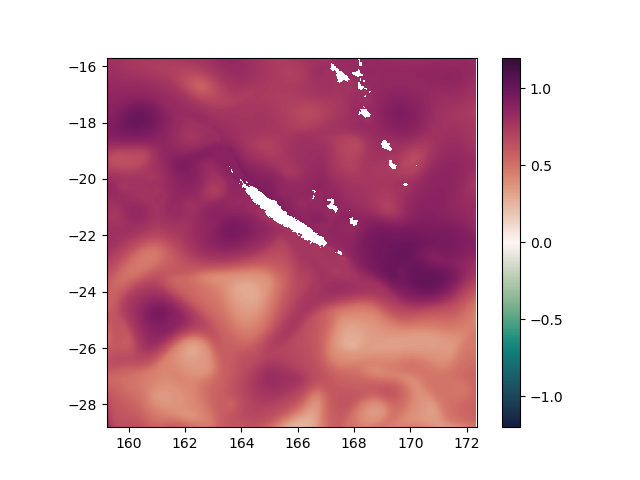

In [28]:
min_val = -1.2
max_val = 1.2

plt.figure()
plt.pcolormesh(ssh_bm.lon, ssh_bm.lat,ssh_bm['__xarray_dataarray_variable__'] , cmap=cmocean.cm.curl, vmin=min_val, vmax=max_val)
plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [30]:
ssh

<xarray.Dataset> Size: 16MB
Dimensions:       (y: 853, x: 788)
Coordinates:
    nav_lat       (y, x) float32 3MB -28.8 -28.8 -28.8 ... -15.7 -15.7 -15.7
    nav_lon       (y, x) float32 3MB 159.2 159.2 159.3 ... 172.3 172.3 172.3
    time_counter  datetime64[ns] 8B 2014-01-10T00:30:00
    latitude      (y, x) float32 3MB -28.8 -28.8 -28.8 ... -15.7 -15.7 -15.7
    longitude     (y, x) float32 3MB 159.2 159.2 159.3 ... 172.3 172.3 172.3
Dimensions without coordinates: y, x
Data variables:
    ssh_dedac     (y, x) float64 5MB nan nan nan nan nan ... nan nan nan nan nan

In [31]:
ssh_adj = ssh['ssh_dedac'] - ssh_bm['__xarray_dataarray_variable__']

In [41]:
ssh_adj

<xarray.DataArray (y: 853, x: 788)> Size: 5MB
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan, -0.46211706, -0.46209282, ...,  0.12072774,
         0.12077472,         nan],
       [        nan, -0.46215664, -0.4621357 , ...,  0.12070754,
         0.12075365,         nan],
       ...,
       [        nan, -0.28550266, -0.28544754, ...,  0.33252342,
         0.33249071,         nan],
       [        nan, -0.28555795, -0.28550192, ...,  0.33252699,
         0.33249866,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
    nav_lat       (y, x) float32 3MB -28.8 -28.8 -28.8 ... -15.7 -15.7 -15.7
    nav_lon       (y, x) float32 3MB 159.2 159.2 159.3 ... 172.3 172.3 172.3
    time_counter  datetime64[ns] 8B 2014-01-10T00:30:00
    latitude      (y, x) float32 3MB -28.8 -28.8 -28.8 ... -15.7 -15.7 -15.7
    longitude     (y, x) float32 3MB 159.2 159.2 159.3 ... 172.3 172.3 172.3
    lat           (y, x) float32 3MB -28.8 -28.8 -28.8 ... -15.7 -15.7 -15.7
    lon           (y, x) float32 3MB 159.2 159.2 159.3 ... 172.3 172.3 172.3
Dimensions without coordinates: y, x

/tmp/ipykernel_2975720/3973058333.py:2: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(ssh_bm.lon, ssh_bm.lat,ssh_bm['__xarray_dataarray_variable__'] , cmap=cmocean.cm.deep)


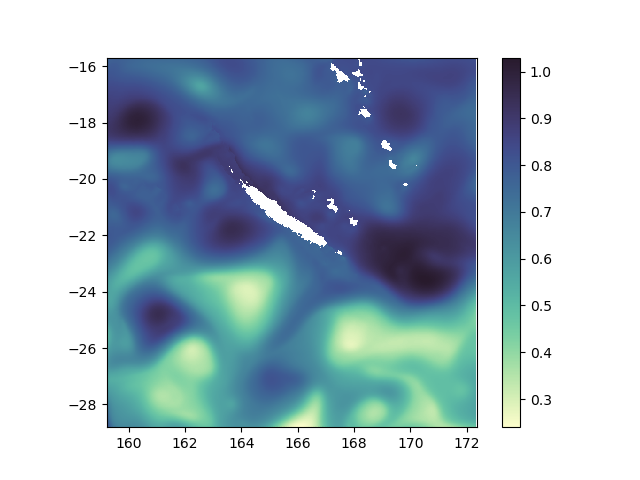

In [34]:
plt.figure()
plt.pcolormesh(ssh_bm.lon, ssh_bm.lat,ssh_bm['__xarray_dataarray_variable__'] , cmap=cmocean.cm.deep)
plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

/tmp/ipykernel_2975720/2798836345.py:12: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(ssh_bm.lon, ssh_bm.lat, masked_data, cmap=cmocean.cm.deep)
/tmp/ipykernel_2975720/2798836345.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmocean.cm.deep)


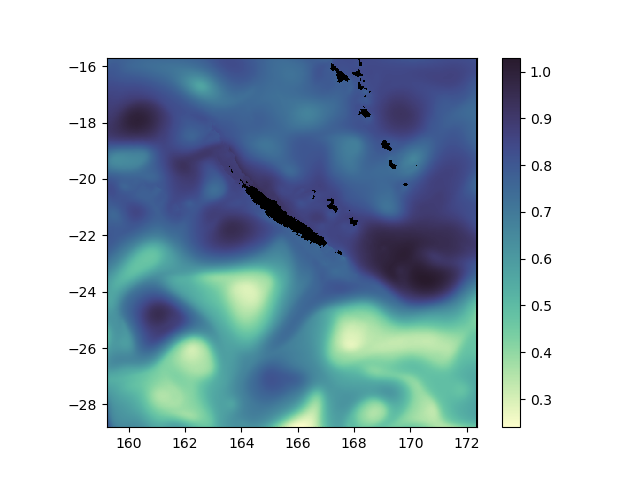

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import cmocean

# Assuming ssh_bm is your xarray dataset and '__xarray_dataarray_variable__' is the variable you are plotting
data = ssh_bm['__xarray_dataarray_variable__'].values

# Mask the missing values
masked_data = np.ma.masked_invalid(data)

plt.figure()
plt.pcolormesh(ssh_bm.lon, ssh_bm.lat, masked_data, cmap=cmocean.cm.deep)

# Set the color for masked values (missing values) to black
cmap = plt.cm.get_cmap(cmocean.cm.deep)
cmap.set_bad(color='black')

plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


In [42]:
lass Axis:
    def __init__(self, values, is_circle):
        self.values = values
        self.is_circle = is_circle

class Grid2D:
    def __init__(self, y_axis, x_axis, values):
        self.y_axis = y_axis
        self.x_axis = x_axis
        self.values = values

# Assuming you have the fill.gauss_seidel method from a specific library
def fill_missing_data(ssh_adj):
    # Create Axis objects for x and y
    x_axis_a = Axis(ssh_adj.x.values, is_circle=True)
    y_axis_a = Axis(ssh_adj.y.values, is_circle=True)
    
    # Create Grid2D object
    grid_a = Grid2D(y_axis_a, x_axis_a, ssh_adj.values.transpose(1, 0))
    
    # Fill missing data using Gauss-Seidel method
    has_converged_a, ssh_adj_filled = fill.gauss_seidel(grid_a)
    
    # Return filled DataArray
    return xr.DataArray(
        ssh_adj_filled,
        dims=ssh_adj.dims,
        coords=ssh_adj.coords
    )

# Fill the missing data in ssh_adj
ssh_adj_filled = fill_missing_data(ssh_adj)

SyntaxError: invalid syntax (1240396871.py, line 1)

In [40]:
has_converged_a, ssh_adj_filled = fill.gauss_seidel(grid_a)

NameError: name 'grid_a' is not defined

In [29]:

# Now create a new DataArray with the resized data
geo_filtered_da_filled_da = xr.DataArray(
    geo_filtered_da_filled_resized, 
    coords={
        'lat': (('y', 'x'), ssh_bm['lat'].values),
        'lon': (('y', 'x'), ssh_bm['lon'].values),
        'time_counter': ssh_bm['time_counter'].values
    },
    dims=['y', 'x']
)

NameError: name 'geo_filtered_da_filled_resized' is not defined

In [38]:
import xarray as xr
import numpy as np
from scipy.ndimage import zoom

# Resample geo_filtered_da_filled to match the dimensions of ssh_bm
geo_filtered_da_filled_resized = zoom(geo_filtered_da_filled, (853 / 213, 788 / 197))

# Now create a new DataArray with the resized data
geo_filtered_da_filled_da = xr.DataArray(
    geo_filtered_da_filled_resized, 
    coords={
        'lat': (('y', 'x'), ssh_bm['lat'].values),
        'lon': (('y', 'x'), ssh_bm['lon'].values),
        'time_counter': ssh_bm['time_counter'].values
    },
    dims=['y', 'x']
)


In [39]:
ssh_bar_debar = ssh_bm['__xarray_dataarray_variable__'] - geo_filtered_da_filled_da

/tmp/ipykernel_1232001/4236284258.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(ssh_bar_debar.lon, ssh_bar_debar.lat, ssh_bar_debar, cmap=cmocean.cm.curl, vmin=min_val, vmax=max_val)


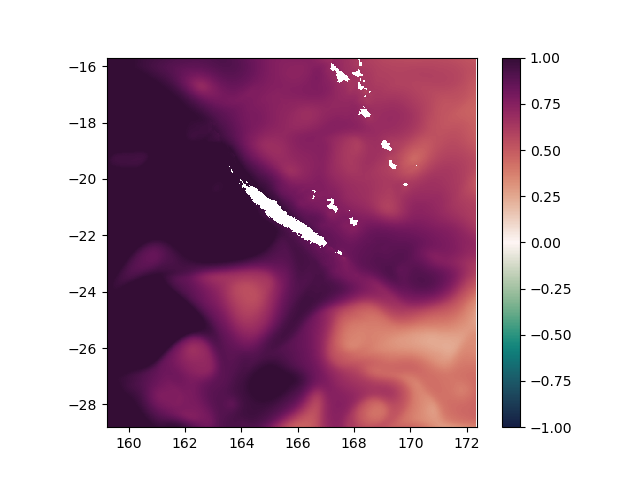

In [ ]:
min_val = -1
max_val = 1

plt.figure()
plt.pcolormesh(ssh_bar_debar.lon, ssh_bar_debar.lat, ssh_bar_debar, cmap=cmocean.cm.curl, vmin=min_val, vmax=max_val)
plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
x_axis_a = Axis(ssh_bar_debar.x.values,is_circle=True)
y_axis_a = Axis(ssh_bar_debar.y.values,is_circle=True)
# print('x_axis,y_axis: ok') # t_axis no longer needed    

grid_a = Grid2D(y_axis_a, x_axis_a, ssh_bar_debar.values.transpose(0,1))
# print('grid: ok') 

has_converged_a, ssh_bar_debar_filled = fill.gauss_seidel(grid_a)

In [ ]:
# Now create a new DataArray with the resized data
ssh_bar_debar_filled = xr.DataArray(
    ssh_bar_debar_filled, 
    coords={
        'lat': (('y', 'x'), ssh_bm['lat'].values),
        'lon': (('y', 'x'), ssh_bm['lon'].values),
        'time_counter': ssh_bm['time_counter'].values
    },
    dims=['y', 'x']
)

/tmp/ipykernel_1232001/991312774.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(ssh_bar_debar_filled.lon, ssh_bar_debar_filled.lat, ssh_bar_debar_filled, cmap=cmocean.cm.curl, vmin=min_val, vmax=max_val)


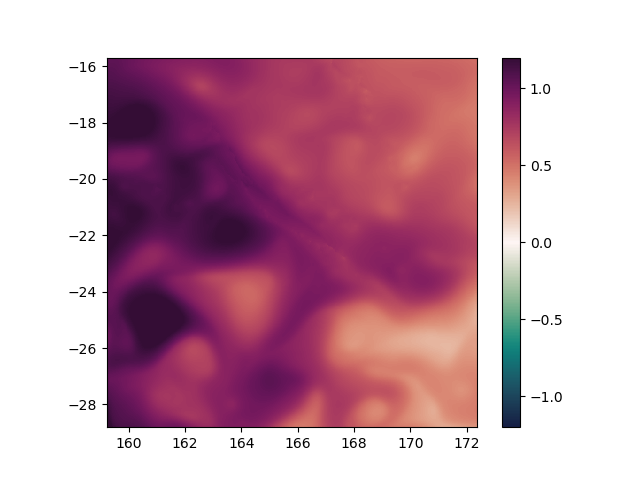

In [ ]:
min_val = -1.2
max_val = 1.2

plt.figure()
plt.pcolormesh(ssh_bar_debar_filled.lon, ssh_bar_debar_filled.lat, ssh_bar_debar_filled, cmap=cmocean.cm.curl, vmin=min_val, vmax=max_val)
plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
ssh_bm

<xarray.Dataset> Size: 11MB
Dimensions:                        (y: 853, x: 788)
Coordinates:
    lat                            (y, x) float32 3MB -28.8 -28.8 ... -15.7
    lon                            (y, x) float32 3MB 159.2 159.2 ... 172.3
    time_counter                   datetime64[ns] 8B 2014-01-10T00:30:00
Dimensions without coordinates: y, x
Data variables:
    __xarray_dataarray_variable__  (y, x) float64 5MB nan nan nan ... nan nan

In [ ]:
has_converged_a, ssh_bm = fill.gauss_seidel(grid_a)

# Now create a new DataArray with the resized data
ssh_b_original = xr.DataArray(
    ssh_bm, 
    
    coords={
        'lat': (('y', 'x'), ssh_bm['lat'].values),
        'lon': (('y', 'x'), ssh_bm['lon'].values),
        'time_counter': ssh_bm['time_counter'].values
    },
    dims=['y', 'x']
)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
ssh_b_original

<xarray.DataArray (y: 853, x: 788)> Size: 5MB
array([[1.2657552 , 1.26556386, 1.26395622, ..., 0.3552093 , 0.35494181,
        0.35512222],
       [1.26596621, 1.26620036, 1.26611961, ..., 0.35526787, 0.35472704,
        0.35527289],
       [1.26555722, 1.26618266, 1.26610001, ..., 0.35516303, 0.35462115,
        0.35653687],
       ...,
       [1.0319208 , 1.03157644, 1.03150028, ..., 0.51210919, 0.51203053,
        0.51229756],
       [1.03157541, 1.03137699, 1.0313004 , ..., 0.51189995, 0.51182331,
        0.51197183],
       [1.03152131, 1.0314706 , 1.03151211, ..., 0.51202375, 0.51190313,
        0.511964  ]])
Coordinates:
    lat           (y, x) float32 3MB -28.8 -28.8 -28.8 ... -15.7 -15.7 -15.7
    lon           (y, x) float32 3MB 159.2 159.2 159.3 ... 172.3 172.3 172.3
    time_counter  datetime64[ns] 8B 2014-01-10T00:30:00
Dimensions without coordinates: y, x

/tmp/ipykernel_1232001/1342315742.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(ssh_b_original.lon, ssh_b_original.lat, ssh_b_original, cmap=cmocean.cm.curl, vmin=min_val, vmax=max_val)


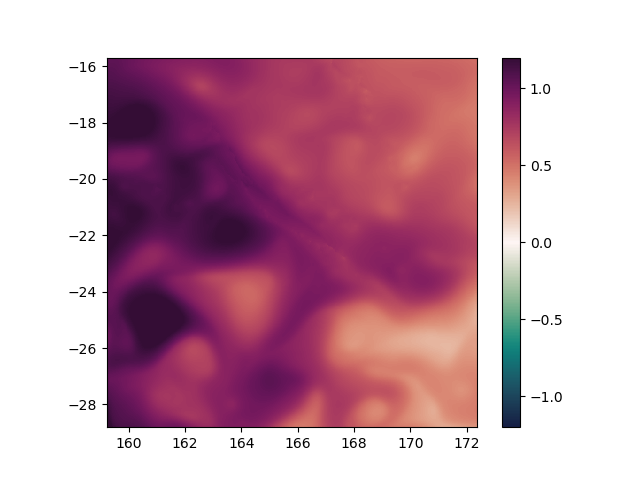

In [ ]:
min_val = -1.2
max_val = 1.2

plt.figure()
plt.pcolormesh(ssh_b_original.lon, ssh_b_original.lat, ssh_b_original, cmap=cmocean.cm.curl, vmin=min_val, vmax=max_val)
plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()